Setting up the Clustering Notebook

In [ ]:
!pip install numpy pandas hdbscan scikit-learn matplotlib seaborn umap-learn # umap-learn for UMAP (optional but good)

load data

In [ ]:
# 1. Install Kaggle API
!pip install kaggle --quiet

# 2. Upload your kaggle.json API token
from google.colab import files
print("Please upload your kaggle.json API token:")
uploaded = files.upload()

# Check if kaggle.json was uploaded
if 'kaggle.json' in uploaded:
    print("kaggle.json uploaded successfully!")
    # 3. Move kaggle.json to the required directory and set permissions
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API token configured.")
else:
    print("ERROR: kaggle.json was not uploaded. Please run this cell again and upload the file.")
    # You might want to stop execution here if the token is missing
    # raise RuntimeError("Kaggle API token not provided.")

Please upload your kaggle.json API token:


Saving kaggle.json to kaggle.json
kaggle.json uploaded successfully!
Kaggle API token configured.


download compettion data

In [ ]:
# 4. Download the competition data
# The -p flag specifies the path to download to. Let's download into the current directory first.
print("Downloading competition data... This might take a few minutes.")
!kaggle competitions download -c image-matching-challenge-2025 -p ./
print("Download command executed.")

# 5. List files to see what was downloaded (usually a .zip file)
!ls

100% 4.82G/4.84G [01:30<00:00, 27.5MB/s]
100% 4.84G/4.84G [01:30<00:00, 57.3MB/s]
Download command executed.
image-matching-challenge-2025.zip  kaggle.json	sample_data


import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import hdbscan
import umap # Optional, for dimensionality reduction/visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Optional, for scaling features
from PIL import Image


# --- Define Helper Functions ---

# It's good to have your data_dir defined
data_dir = './data/' # Adjust if your data is elsewhere relative to the notebook

def get_image_path_from_id(image_id_combined, train_df, base_dir_default='./data/train'):
    """
    Constructs the full image path from a combined ID like 'dataset_name__image_filename.png'
    and a DataFrame containing 'dataset' and 'image' columns.
    """
    parts = image_id_combined.split('__')
    if len(parts) == 2:
        dataset_name, image_filename = parts
        # Find the original row to ensure we use the correct base_dir if it varied
        # This is a bit inefficient if done repeatedly for many images,
        # a pre-built lookup dictionary is better (see step 2B)
        # For now, let's assume base_dir_default is fine for all.
        return os.path.join(base_dir_default, dataset_name, image_filename)
    else:
        print(f"Warning: Could not parse image_id_combined: {image_id_combined}")
        return None


def open_image(img_paths, titles, n_cols=5, figsize_per_img=(4, 4)):
    """
    Displays multiple images with titles.
    img_paths: List of full paths to images.
    titles: List of titles corresponding to each image.
    n_cols: Number of columns in the plot.
    figsize_per_img: Tuple (width, height) for each individual image subplot.
    """
    if not img_paths:
        print("No image paths provided to open_image.")
        return

    n_images = len(img_paths)
    if n_images == 0:
        print("Empty list of image paths.")
        return

    n_rows = (n_images + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig_width = n_cols * figsize_per_img[0]
    fig_height = n_rows * figsize_per_img[1]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    if n_images == 1: # If only one image, axes is not an array
        axes = np.array([axes])
    axes = axes.flatten() # Flatten to easily iterate

    for i, img_path in enumerate(img_paths):
        if i >= len(axes):
            break

        current_title = titles[i] if i < len(titles) else "No Title"

        if img_path and os.path.exists(img_path):
            try:
                img_pil = Image.open(img_path).convert("RGB") # Ensure RGB for matplotlib
                axes[i].imshow(img_pil)
                axes[i].set_title(current_title, fontsize=10)
            except Exception as e:
                axes[i].set_title(f"Error loading:\n{os.path.basename(str(img_path))}\n{e}", fontsize=8, color='red')
                print(f"Error loading {img_path}: {e}")
        else:
            axes[i].set_title(f"Not found or invalid:\n{os.path.basename(str(img_path))}", fontsize=8, color='orange')
            print(f"Image path not found or invalid: {img_path}")

        axes[i].axis("off") # Turn off axis for all subplots

    # Turn off axes for any unused subplots
    for j in range(n_images, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


In [ ]:
# 6. Create the target directory structure if it doesn't exist
!mkdir -p ./data/image-matching-challenge-2025

# 7. Unzip the downloaded file into the target directory
# Replace 'image-matching-challenge-2025.zip' if your downloaded file has a different name
zip_file_name = 'image-matching-challenge-2025.zip' # Check 'ls' output from previous cell to confirm

if os.path.exists(zip_file_name):
    print(f"Unzipping {zip_file_name} into ./data/image-matching-challenge-2025/ ... This might take some time.")
    !unzip -q {zip_file_name} -d ./data/image-matching-challenge-2025/
    print("Unzipping complete.")

    # 8. Verify the contents
    print("\nContents of ./data/ :")
    !ls ./data/
    print("\nContents of ./data/image-matching-challenge-2025/ :")
    !ls ./data/image-matching-challenge-2025/
    print("\nContents of ./data/image-matching-challenge-2025/train/ (first few items):")
    !ls ./data/image-matching-challenge-2025/train/ | head
else:
    print(f"ERROR: {zip_file_name} not found. Download might have failed or file has a different name.")

Unzipping image-matching-challenge-2025.zip into ./data/image-matching-challenge-2025/ ... This might take some time.
Unzipping complete.

Contents of ./data/ :
image-matching-challenge-2025

Contents of ./data/image-matching-challenge-2025/ :
sample_submission.csv  test  train  train_labels.csv  train_thresholds.csv

Contents of ./data/image-matching-challenge-2025/train/ (first few items):
amy_gardens
ETs
fbk_vineyard
imc2023_haiper
imc2023_heritage
imc2023_theather_imc2024_church
imc2024_dioscuri_baalshamin
imc2024_lizard_pond
pt_brandenburg_british_buckingham
pt_piazzasanmarco_grandplace


In [ ]:
# IN YOUR CLUSTERING NOTEBOOK - CELL THAT LOADS TRAIN_LABELS_DF
data_root_dir = './data/image-matching-challenge-2025/' # Root of the competition data
csv_path = os.path.join(data_root_dir, 'train_labels.csv')
base_images_train_dir = os.path.join(data_root_dir, 'train') # Path to the 'train' folder

print(f"Attempting to load train_labels.csv from: {csv_path}")
if os.path.exists(csv_path):
    train_labels_df = pd.read_csv(csv_path)
    print(f"train_labels_df loaded. Shape: {train_labels_df.shape}")

    def create_full_path(row):
        if pd.notna(row['dataset']) and pd.notna(row['image']):
            return os.path.join(base_images_train_dir, str(row['dataset']), str(row['image']))
        return None

    train_labels_df['full_path'] = train_labels_df.apply(create_full_path, axis=1)
    train_labels_df['image_id_combined'] = train_labels_df['dataset'].astype(str) + "__" + train_labels_df['image'].astype(str)

    path_lookup = pd.Series(train_labels_df.full_path.values, index=train_labels_df.image_id_combined).to_dict()
    print("'full_path', 'image_id_combined' columns added, and 'path_lookup' dictionary created.")
    print(f"Example full_path: {train_labels_df['full_path'].iloc[0]}")
    print(f"Example image_id_combined: {train_labels_df['image_id_combined'].iloc[0]}")
    print(f"Path for example id from lookup: {path_lookup.get(train_labels_df['image_id_combined'].iloc[0])}")

else:
    print(f"ERROR: {csv_path} not found.")
    train_labels_df = pd.DataFrame() # Prevent errors
    path_lookup = {}

Attempting to load train_labels.csv from: ./data/image-matching-challenge-2025/train_labels.csv
train_labels_df loaded. Shape: (1945, 5)
'full_path', 'image_id_combined' columns added, and 'path_lookup' dictionary created.
Example full_path: ./data/image-matching-challenge-2025/train/imc2023_haiper/fountain_image_116.png
Example image_id_combined: imc2023_haiper__fountain_image_116.png
Path for example id from lookup: ./data/image-matching-challenge-2025/train/imc2023_haiper/fountain_image_116.png


load embeddings

In [ ]:
from google.colab import files
uploaded = files.upload() # This will prompt you to upload
embeddings_npz_path = next(iter(uploaded)) # Gets the name of the uploaded file

Saving full_train_embeddings_vits.npz to full_train_embeddings_vits.npz


load the npz file

In [ ]:
print(f"Loading embeddings from: {embeddings_npz_path}")
loaded_data = np.load(embeddings_npz_path)

image_ids = [] # Will store 'dataset_name__image_filename'
embeddings_list = []

for key in loaded_data.files:
    image_ids.append(key)
    embeddings_list.append(loaded_data[key])

loaded_data.close() # Good practice for npz files

embeddings_matrix = np.array(embeddings_list)
print(f"Loaded embeddings matrix with shape: {embeddings_matrix.shape}") # Should be (num_images, 384) for ViT-S

# Create a DataFrame for easier handling of image_ids and later cluster labels
# This assumes image_ids are in the same order as rows in embeddings_matrix
embeddings_df = pd.DataFrame({'image_id': image_ids})

Loading embeddings from: full_train_embeddings_vits.npz
Loaded embeddings matrix with shape: (1945, 384)


pre clustering steps

In [ ]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_matrix)
data_for_clustering = scaled_embeddings

Dimensionality Reduction with UMAP

In [ ]:
print("Applying UMAP for dimensionality reduction...")
# Experiment with n_neighbors, n_components, min_dist, metric
# n_components could be e.g., 10-50 for feeding into HDBSCAN, or 2-3 for direct visualization
reducer = umap.UMAP(
    n_neighbors=15,     # Default 15. Lower for local structure, higher for global.
    n_components=30,    # Target dimension. Try different values. 50 is often good for HDBSCAN.
    min_dist=0.0,       # Default 0.1. How tightly points are packed. 0.0 can give tighter clusters.
    metric='cosine',    # Cosine distance is often good for high-dim embeddings.
    random_state=42     # For reproducibility
)
reduced_embeddings = reducer.fit_transform(embeddings_matrix) # Or scaled_embeddings if you used scaler
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")
data_for_clustering = reduced_embeddings

Applying UMAP for dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced embeddings shape: (1945, 30)


Apply HDBSCAN Clustering

In [ ]:
print("Applying HDBSCAN...")
# Experiment with min_cluster_size, min_samples, cluster_selection_epsilon
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,     # Minimum number of points to form a cluster. Key parameter!
    min_samples=None,       # How conservative to be. None often works well.
    metric='euclidean',     # UMAP often transforms data to be suitable for Euclidean.
    # allow_single_cluster=True, # If you expect some datasets might only have one scene
    prediction_data=True    # If you want to predict new points later (not essential now)
)
cluster_labels = clusterer.fit_predict(data_for_clustering)

embeddings_df['hdbscan_cluster_label'] = cluster_labels

# Analyze cluster results
n_clusters_hdbscan = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0) # -1 is noise/outliers
n_noise_hdbscan = np.sum(cluster_labels == -1)

print(f"\nHDBSCAN found {n_clusters_hdbscan} clusters and {n_noise_hdbscan} noise points.")
print("Cluster label counts:")
print(embeddings_df['hdbscan_cluster_label'].value_counts().sort_index())

Applying HDBSCAN...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



HDBSCAN found 62 clusters and 49 noise points.
Cluster label counts:
hdbscan_cluster_label
-1      49
 0      75
 1      98
 2     116
 3      48
      ... 
 57      6
 58     12
 59     14
 60     14
 61     10
Name: count, Length: 63, dtype: int64


visualising clusters

Generating 2D UMAP for visualization from original embeddings...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2D UMAP embeddings for visualization shape: (1945, 2)


<ipython-input-15-84c33235ac50>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viz = plt.cm.get_cmap('viridis', n_clusters_hdbscan if n_clusters_hdbscan > 0 else 1)
<ipython-input-15-84c33235ac50>:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1],


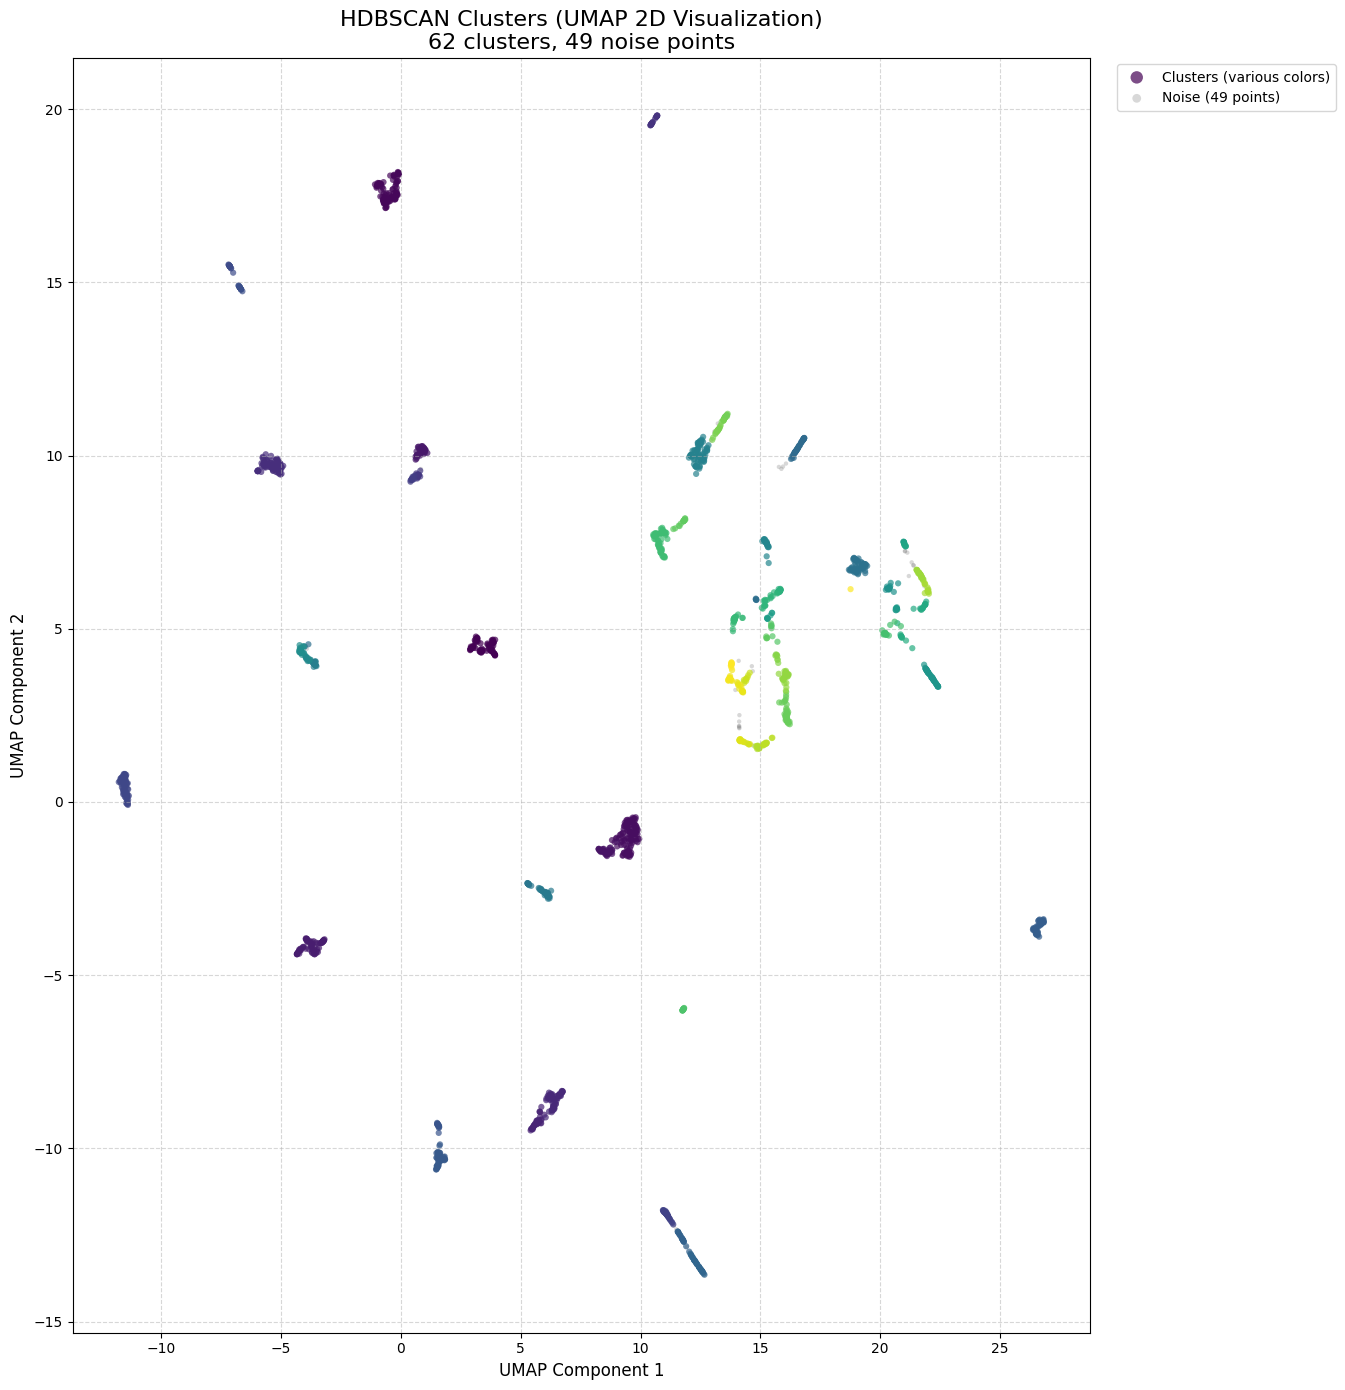

In [ ]:
# --- Re-plot UMAP with Explicit Noise Coloring ---

# For visualization, let's create a 2D UMAP from the original embeddings_matrix
# This ensures the visualization is not based on the potentially higher-dim UMAP used for clustering itself
print("Generating 2D UMAP for visualization from original embeddings...")
viz_reducer = umap.UMAP(
    n_neighbors=15,     # Standard UMAP default
    n_components=2,     # We want a 2D plot
    min_dist=0.1,       # Standard UMAP default, gives decent spread
    metric='cosine',    # Good for DINOv2 embeddings
    random_state=42
)
viz_embeddings_2d = viz_reducer.fit_transform(embeddings_matrix)
print(f"2D UMAP embeddings for visualization shape: {viz_embeddings_2d.shape}")

plt.figure(figsize=(16, 14)) # Made figure larger
unique_labels_viz = np.unique(cluster_labels)
# Using a colormap that has many distinct colors + manually setting grey for noise
# For many clusters, 'tab20', 'tab20b', 'tab20c' are good, or combining them.
# Let's use 'viridis' and handle noise separately.
cmap_viz = plt.cm.get_cmap('viridis', n_clusters_hdbscan if n_clusters_hdbscan > 0 else 1)

# Keep track of labels for legend to avoid duplicates if plotting in loop
handles_labels = {}

for i, label in enumerate(unique_labels_viz):
    label_mask = (cluster_labels == label)
    points_to_plot = viz_embeddings_2d[label_mask]

    if label == -1:
        color = 'grey'
        point_size = 10
        alpha_val = 0.3
        legend_label = f'Noise ({np.sum(label_mask)} points)'
    else:
        # Map cluster labels (0 to N) to colormap indices
        color_idx = label % (n_clusters_hdbscan if n_clusters_hdbscan > 0 else 1) # Cycle through colors if more clusters than cmap distinct colors
        color = cmap_viz(color_idx / (n_clusters_hdbscan if n_clusters_hdbscan > 0 else 1.0))
        point_size = 20
        alpha_val = 0.7
        legend_label = f'Cluster {label} ({np.sum(label_mask)} points)'

    scatter = plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1],
                c=[color] if isinstance(color, str) else color, # Scatter expects list of colors if providing actual color value for c
                s=point_size,
                label=legend_label,
                alpha=alpha_val,
                edgecolors='none') # No distracting edges on points
    handles_labels[legend_label] = scatter


plt.title(f'HDBSCAN Clusters (UMAP 2D Visualization)\n{n_clusters_hdbscan} clusters, {n_noise_hdbscan} noise points', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)

# Create a more manageable legend if many clusters
if len(handles_labels) > 20:
    # For many clusters, a full legend is too much. Maybe just show noise vs. clusters.
    noise_handle = handles_labels.get(f'Noise ({n_noise_hdbscan} points)')
    # Get one example cluster handle
    cluster_example_label = next((k for k in handles_labels if 'Cluster' in k), None)
    cluster_handle = handles_labels.get(cluster_example_label)

    handles_for_legend = []
    labels_for_legend = []
    if cluster_handle:
        handles_for_legend.append(cluster_handle)
        labels_for_legend.append("Clusters (various colors)")
    if noise_handle:
        handles_for_legend.append(noise_handle)
        labels_for_legend.append(f'Noise ({n_noise_hdbscan} points)')
    if handles_for_legend:
         plt.legend(handles_for_legend, labels_for_legend, markerscale=2, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
elif handles_labels:
    plt.legend(handles_labels.values(), handles_labels.keys(), markerscale=2, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

examine images displlayed for each cluster

Inspecting clusters: [-1, 0, 1, 2, 3, 4]

--- Sampling images from Cluster: -1 ---


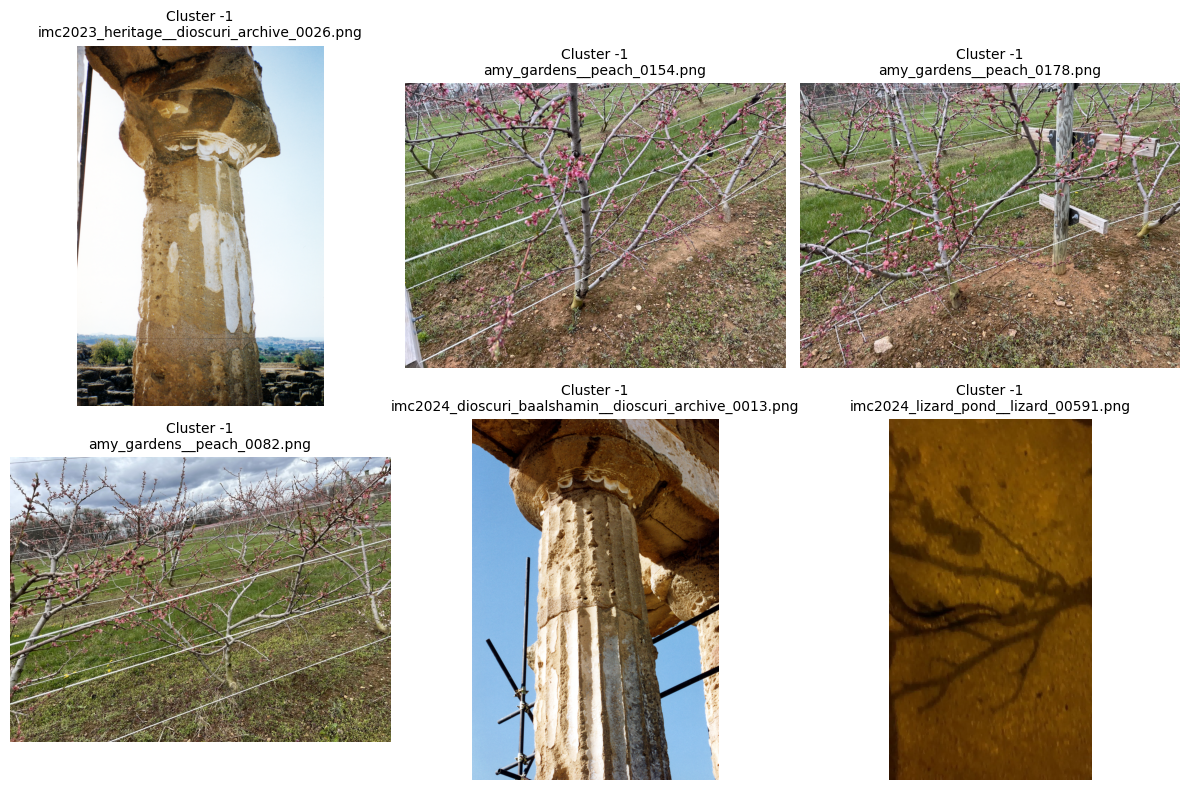


--- Sampling images from Cluster: 0 ---


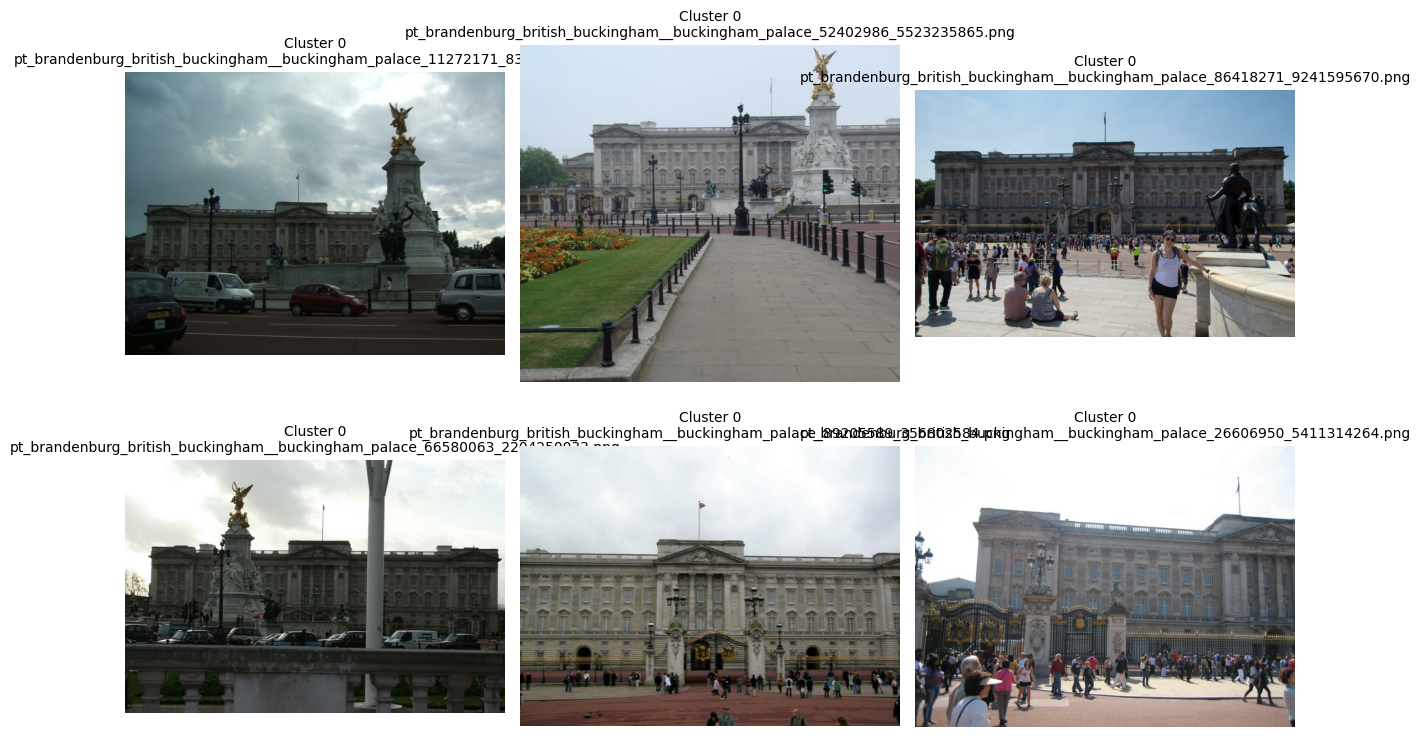


--- Sampling images from Cluster: 1 ---


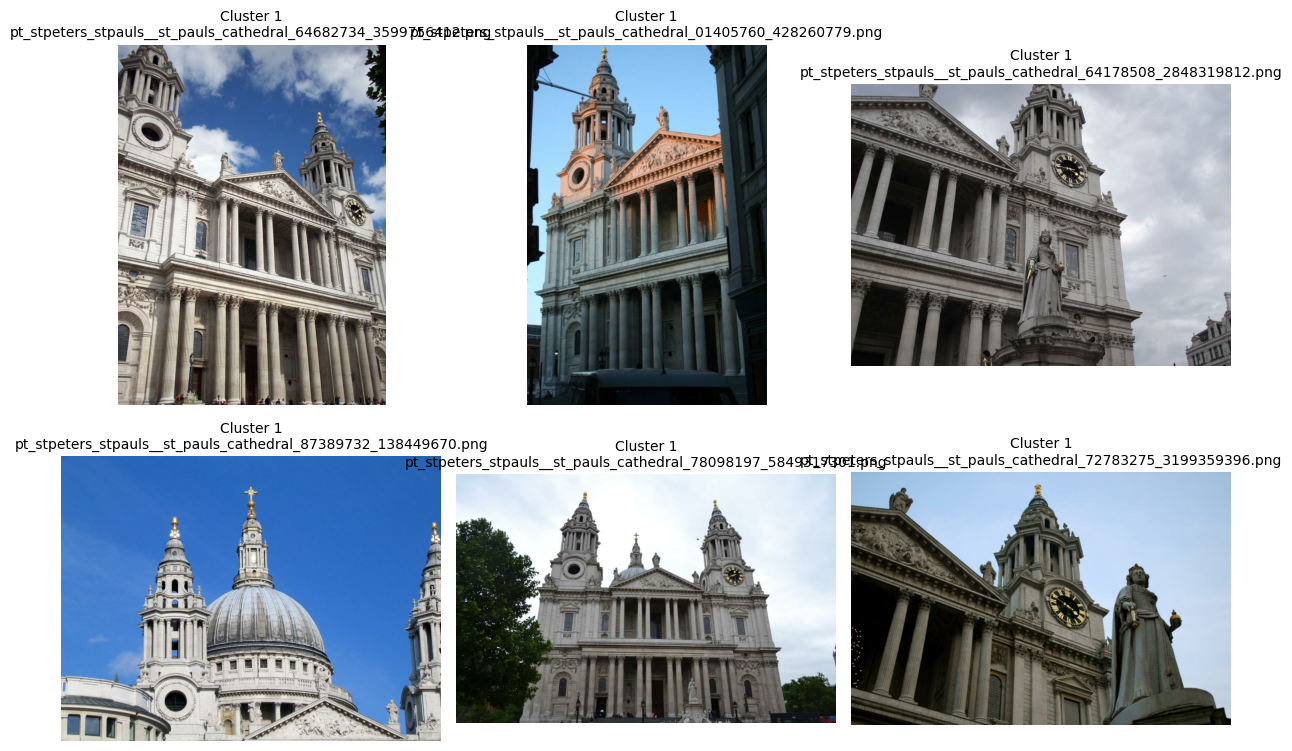


--- Sampling images from Cluster: 2 ---


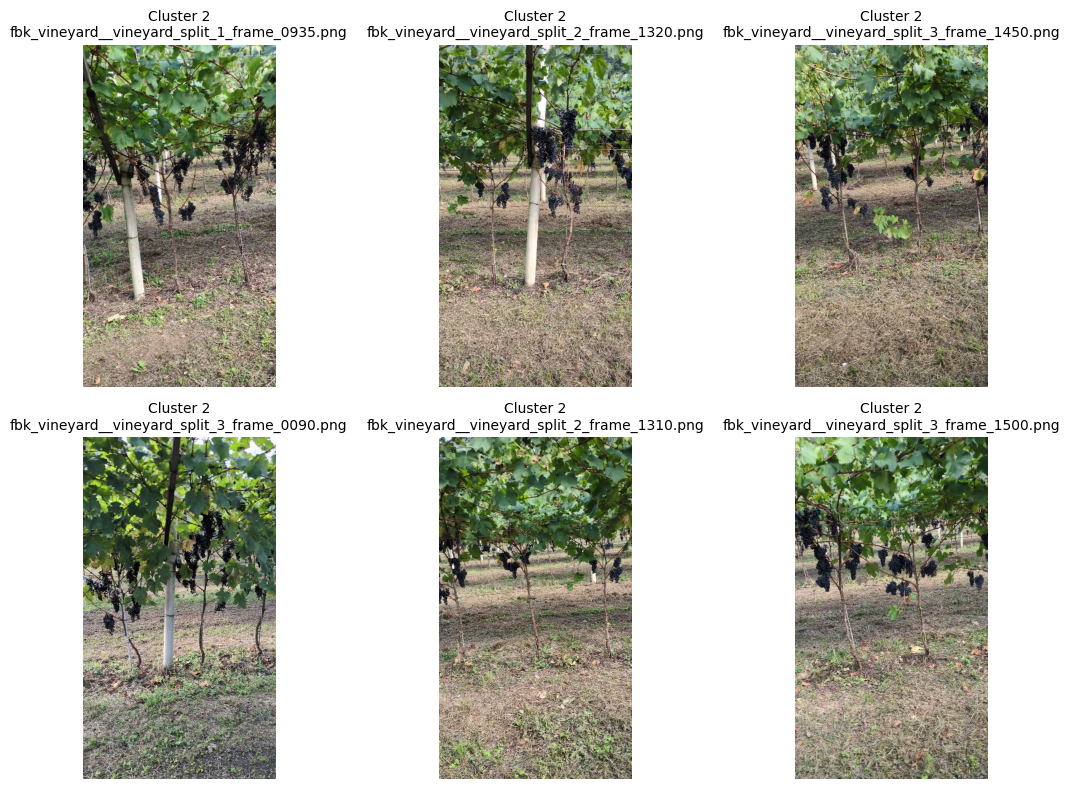


--- Sampling images from Cluster: 3 ---


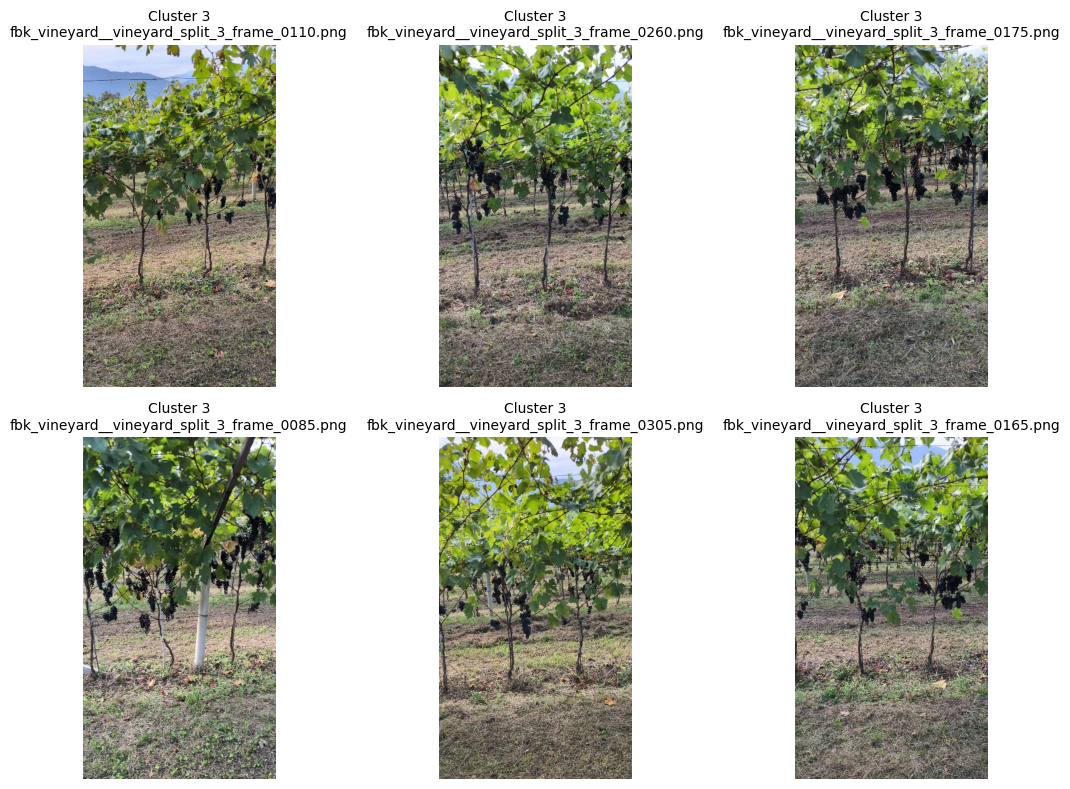


--- Sampling images from Cluster: 4 ---


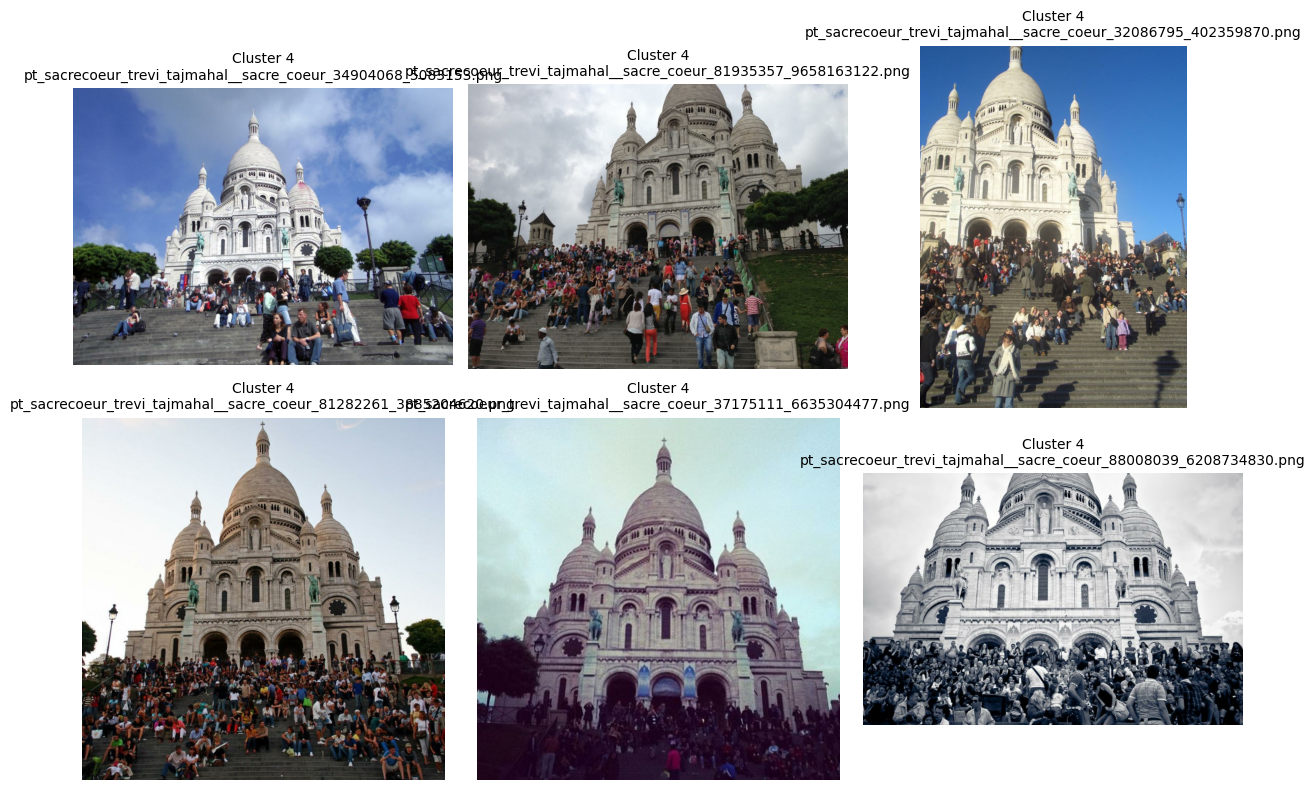

In [ ]:
# --- Prepare image_ids and cluster_labels in a DataFrame for easier sampling ---
# This assumes image_ids is a list/array of your 'dataset__image.png' identifiers
# and cluster_labels is the corresponding array of labels from HDBSCAN.
# And train_labels_df is your original DataFrame with 'dataset', 'image', 'full_path'

# Create a combined ID in train_labels_df if it doesn't exist, for robust lookup
if 'image_id_combined' not in train_labels_df.columns:
    train_labels_df['image_id_combined'] = train_labels_df['dataset'].astype(str) + "__" + train_labels_df['image'].astype(str)

# Create a lookup dictionary from combined_id to full_path
path_lookup = pd.Series(train_labels_df.full_path.values, index=train_labels_df.image_id_combined).to_dict()

# Create a DataFrame from your current clustering results
results_df = pd.DataFrame({
    'image_id': image_ids, # This should be your list of 'dataset__filename' that matches embeddings_matrix
    'hdbscan_cluster_label': cluster_labels
})

# --- Display samples ---
num_samples_per_cluster = 6 # How many images to show per cluster
n_display_cols = 3          # How many columns for the image display

# Decide which clusters to inspect:
# Option 1: Largest clusters + noise
# cluster_counts = results_df['hdbscan_cluster_label'].value_counts()
# clusters_to_inspect = list(cluster_counts.head(5).index) # Top 5 largest
# if -1 not in clusters_to_inspect and -1 in cluster_counts.index:
#    clusters_to_inspect.append(-1) # Add noise if present and not in top 5

# Option 2: Specific clusters based on UMAP plot or your interest
# For example, if you saw an interesting isolated cluster or one from a dense area
clusters_to_inspect = [-1, 0, 1, 2, 3, 4] # Example: noise and first 5 clusters. Adjust as needed!
# You can also pick by looking at your UMAP plot and choosing cluster IDs that look interesting.

print(f"Inspecting clusters: {clusters_to_inspect}")

for cluster_id_to_inspect in clusters_to_inspect:
    if cluster_id_to_inspect not in results_df['hdbscan_cluster_label'].unique():
        print(f"Cluster ID {cluster_id_to_inspect} not found in results. Skipping.")
        continue

    print(f"\n--- Sampling images from Cluster: {cluster_id_to_inspect} ---")

    # Get image_ids for this cluster
    ids_in_cluster_df = results_df[results_df['hdbscan_cluster_label'] == cluster_id_to_inspect]

    if ids_in_cluster_df.empty:
        print(f"No images found for cluster {cluster_id_to_inspect}.")
        continue

    # Randomly sample images or take the first few
    sample_df = ids_in_cluster_df.sample(n=min(num_samples_per_cluster, len(ids_in_cluster_df)), random_state=42)

    sample_image_ids_combined = sample_df['image_id'].tolist()
    sample_paths = [path_lookup.get(img_id) for img_id in sample_image_ids_combined]
    # Filter out any paths that might be None if an image_id wasn't in path_lookup (shouldn't happen if data is consistent)
    valid_sample_paths = [p for p in sample_paths if p is not None and os.path.exists(p)]
    valid_sample_ids = [sid for sid, p in zip(sample_image_ids_combined, sample_paths) if p is not None and os.path.exists(p)]


    if valid_sample_paths:
        # Create titles using the original image_id (dataset__filename)
        titles = [f"Cluster {cluster_id_to_inspect}\n{img_id}" for img_id in valid_sample_ids]
        open_image(valid_sample_paths, titles, n_cols=n_display_cols)
    else:
        print(f"No valid image paths could be retrieved for sampling from cluster {cluster_id_to_inspect}.")
        if sample_image_ids_combined:
             print(f"Problematic combined IDs were: {sample_image_ids_combined}")

## Visual Inspection of HDBSCAN Clusters

**Parameters Used:**
*   **Embeddings:** DINOv2 ViT-Small (384-dim) from `full_train_embeddings_vits.npz`.
*   **UMAP Reduction:**
    *   `n_neighbors`: 15
    *   `n_components`: 30 (for input to HDBSCAN)
    *   `min_dist`: 0.0
    *   `metric`: 'cosine'
    *   `random_state`: 42
*   **HDBSCAN:**
    *   `min_cluster_size`: 5
    *   `metric`: 'euclidean' (on UMAP output)
    *   `min_samples`: None

**Summary of Results:**
*   Number of clusters found (excluding noise): 62
*   Number of noise points (label -1): 49

**(Embed your UMAP plot with noise coloring here if you haven't already in a previous Markdown cell)**

**Observations from Sampled Clusters:**

*   **Cluster 0 (Buckingham Palace - `pt_brandenburg_british_buckingham`):**
    *   Images are all clearly of Buckingham Palace.
    *   Good variety in viewpoints and lighting.
    *   Appears to be a highly coherent and valid scene cluster.

*   **Cluster 1 (St. Paul's Cathedral - `pt_stpeters_stpauls`):**
    *   All images depict St. Paul's Cathedral.
    *   Shows different facades, dome, and includes some foreground elements like statues.
    *   Another strong, valid scene cluster.

*   **Cluster 2 (Vineyard - `fbk_vineyard`):**
    *   All images are from a vineyard, showing rows of vines. Viewpoints are relatively consistent.
    *   Highly coherent cluster representing a distinct environment.

*   **Cluster 4 (Sacre-Coeur Basilica - `pt_sacrecoeur_trevi_tajmahal`):**
    *   All images are of Sacre-Coeur Basilica.
    *   Includes varied angles, crowd levels, and even a grayscale image, all correctly grouped.
    *   Excellent and valid scene cluster.

*   **Cluster -1 (Noise/Outliers):**
    *   Contains a mix of images:
        *   Apparent small, distinct scenes that didn't meet `min_cluster_size` (e.g., several 'amy_gardens__peach' images).
        *   Close-up architectural details (e.g., 'dioscuri_archive' column pieces).
        *   Genuinely ambiguous or low-quality images (e.g., the abstract 'lizard_pond' sample).
    *   This suggests that some "noise" might be recoverable as small scenes if `min_cluster_size` is lowered, while other noise is legitimate.

**Overall Conclusion for this Run (CLUST001):**
The current parameters yield promising results, with major landmarks and distinct environments forming coherent clusters. The number of clusters and noise points seems reasonable as a baseline. Further refinement could involve experimenting with `min_cluster_size` to potentially capture smaller valid scenes currently in noise, or tuning UMAP parameters if some clusters appear over-split upon wider inspection. For now, these results are a good starting point for downstream tasks.

**Next Steps:**
1.  Save these cluster assignments (`image_id` mapped to `hdbscan_cluster_label`) to a CSV file.
2.  Refactor the core clustering logic into a reusable Python script (`src/clustering/hdbscan_clusterer.py`).